In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

dataset = yf.download('BTC-EUR', period='max', interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-09,61124.921875,63992.132812,60486.019531,62411.535156,62411.535156,54098645569
2024-03-10,62410.769531,62752.339844,62185.855469,62593.183594,62593.183594,19746552762
2024-03-11,62594.437500,63969.632812,62389.562500,63072.972656,63072.972656,32609410343
2024-03-12,63073.671875,66681.351562,61394.554688,65983.203125,65983.203125,60121474891
2024-03-13,65408.882812,67423.226562,65343.339844,67301.531250,67301.531250,58243018752


In [4]:
# describe data
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3466.000000,3466.000000,3466.000000,3466.000000,3466.000000,3.466000e+03
mean,13602.456106,13913.413640,13278.506894,13620.430257,13620.430257,1.499092e+10
std,14819.559098,15167.671209,14459.254344,14843.932453,14843.932453,1.675532e+10
min,150.128998,183.047470,145.483078,151.152512,151.152512,4.640334e+06
25%,919.609787,939.306778,893.059891,923.225632,923.225632,1.784987e+08
50%,7405.542480,7603.579346,7227.367676,7414.778076,7414.778076,1.103496e+10
75%,24089.773438,24448.961914,23846.444824,24102.009277,24102.009277,2.484461e+10
max,65408.882812,67423.226562,65343.339844,67301.531250,67301.531250,2.907271e+11


In [5]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


### Data preparation
We create the target variable "signal" that will indicate whether the trading signal is buy or sell. We define the short-term price as the 10-days rolling average and the long-term price as the 60-day rolling average. We use the label 1 (BUY signal) if the short-term is higher than the long-term price
#### Target variable

In [6]:
# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

#### Feature engineering

In [7]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / \
    d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume,short_mavg,long_mavg,signal,EMA10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-09,61124.921875,63992.132812,60486.019531,62411.535156,62411.535156,54098645569,59324.157813,45231.270378,1.0,58720.545272,...,62.285118,86.424276,83.141400,93.083050,89.978431,96.125927,94.132702,59324.157813,51296.732292,35578.226953
2024-03-10,62410.769531,62752.339844,62185.855469,62593.183594,62593.183594,19746552762,59816.553125,45571.048372,1.0,59424.661331,...,62.342729,85.006023,84.151230,93.636781,92.018098,96.571151,95.465782,59816.553125,51982.083333,35771.193838
2024-03-11,62594.437500,63969.632812,62389.562500,63072.972656,63072.972656,32609410343,60460.466406,45914.126953,1.0,60087.990662,...,62.494810,90.148415,87.192905,95.516111,94.078647,97.747122,96.814733,60460.466406,52627.274349,35964.928096
2024-03-12,63073.671875,66681.351562,61394.554688,65983.203125,65983.203125,60121474891,61301.448047,46310.169727,1.0,61159.847474,...,63.395983,94.191435,89.781958,96.900990,95.351294,98.394640,97.570971,61301.448047,53350.183854,36173.707227
2024-03-13,65408.882812,67423.226562,65343.339844,67301.531250,67301.531250,58243018752,62312.139062,46780.439518,1.0,62276.517251,...,63.792073,99.046362,94.462071,99.473274,97.296792,99.724861,98.622208,62312.139062,54102.762370,36389.567812


In [8]:
#excluding columns that are not needed for our prediction.
dataset=dataset.drop(['High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)

In [9]:
dataset = dataset.dropna(axis=0)

### Data visualization

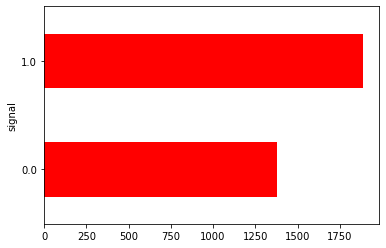

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

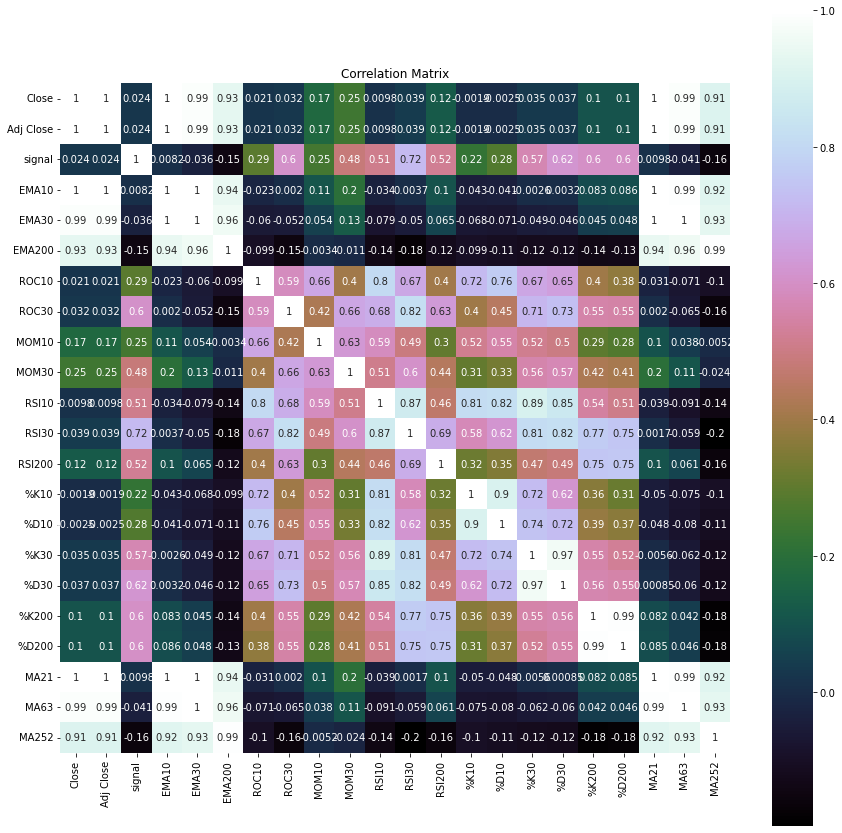

In [11]:
import seaborn as sns
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

### Evaluate Models

In [12]:
# Train-Test split
from sklearn.model_selection import train_test_split
Y= dataset["signal"]
X = dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [13]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [16]:
from sklearn.model_selection import KFold, cross_val_score
# k-fold cross validation
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.925437 (0.020551)
LDA: 0.912856 (0.013185)
KNN: nan (nan)
CART: 0.918632 (0.020320)
NB: 0.818227 (0.027739)
NN: 0.833230 (0.052024)
AB: 0.930543 (0.019192)
GBM: 0.944510 (0.010165)
RF: 0.960514 (0.009418)


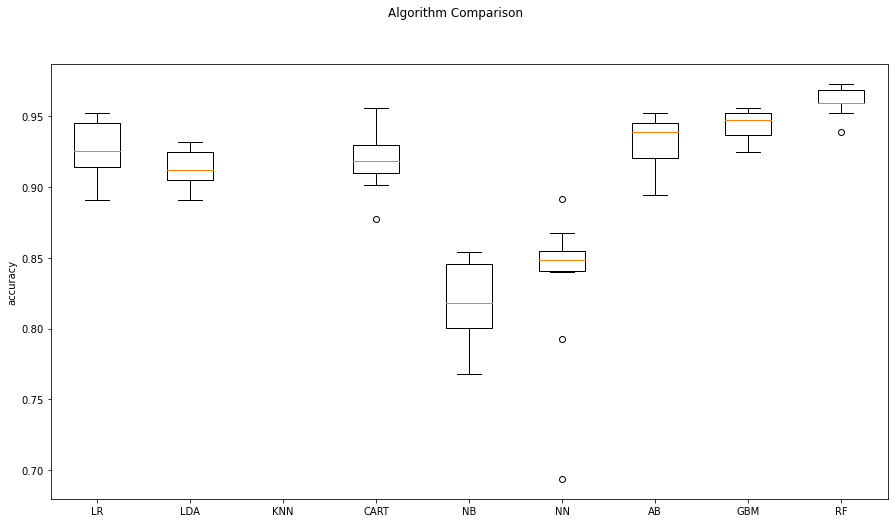

In [17]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel(scoring)
fig.set_size_inches(15,8)
plt.show()

### Model tuning and grid search

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
# Grid Search: Random Forest Classifier
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20, 80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.957794 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.915227 (0.020501) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.918305 (0.012416) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#4 0.952000 (0.010306) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.957794 (0.009648) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.913196 (0.014688) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#6 0.917284 (0.013487) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#2 0.957792 (0.008651) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#3 0.954048 (0.008380) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


### Result on test dataset

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
model.fit(X_train, Y_train)

# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.944954128440367
[[125   8]
 [ 10 184]]
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       133
         1.0       0.96      0.95      0.95       194

    accuracy                           0.94       327
   macro avg       0.94      0.94      0.94       327
weighted avg       0.95      0.94      0.95       327



<Axes: xlabel='Predicted', ylabel='Actual'>

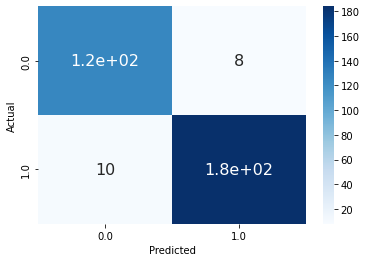

In [29]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

#### Look at the feature importance

Text(0.5, 0, 'Variable Importance')

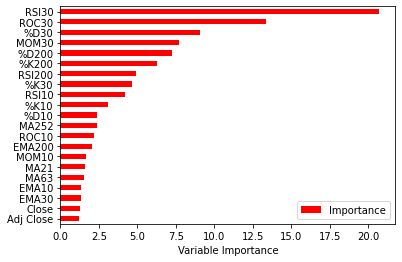

In [30]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

### Backtesting

<Axes: >

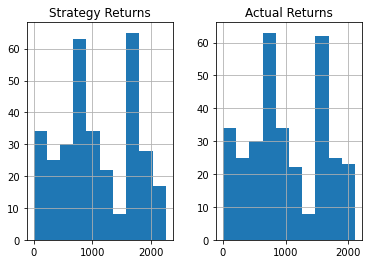

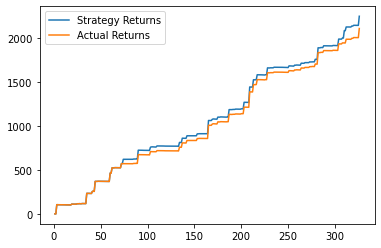

In [31]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()